# 1. Train a deeper Transformer in the experiments. How does it affect the training speed and the translation performance?

In [15]:
import sys
import torch.nn as nn
import torch
import warnings
import time
import math
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

class PositionWiseFFN(nn.Module):  #@save
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))
    
class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)
    
class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
    
class TransformerEncoder(d2l.Encoder):  #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X
    
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
    
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights
    
def experiment(num_blks, data):
    num_hiddens, dropout = 256, 0.2
    ffn_num_hiddens, num_heads = 64, 4
    encoder = TransformerEncoder(
        len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
        num_blks, dropout)
    decoder = TransformerDecoder(
        len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
        num_blks, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                        lr=0.001)
    trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
    t0 = time.time()
    trainer.fit(model, data)
    t1 = time.time()
    src_array, tgt, src_valid_len, y = next(iter(data.get_dataloader(False)))
    val_loss = model.loss(model(src_array, tgt, src_valid_len),y)
    return val_loss, t1-t0

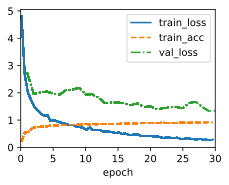

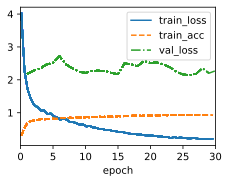

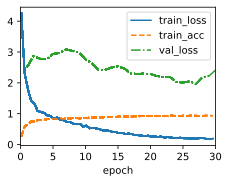

In [19]:
data = d2l.MTFraEng(batch_size=128)
num_blks_list = [1, 2, 3]
loss_list = []
ts = []
for num_blks in num_blks_list:
    loss, t = experiment(num_blks, data)
    loss_list.append(loss)
    ts.append(t)

IndexError: list index out of range

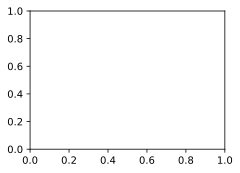

In [17]:
d2l.plot(num_blks_list,loss_list)

# 2. Is it a good idea to replace scaled dot product attention with additive attention in the Transformer? Why?

There is no definitive answer to whether it is a good idea to replace scaled dot-product attention with additive attention in the Transformer, as different attention mechanisms may have different advantages and disadvantages depending on the task and the data. However, based on some existing research and experiments, we can try to compare and contrast the two methods and discuss some possible factors that may affect their performance.

One factor is the computational efficiency and scalability of the attention mechanisms. Scaled dot-product attention is faster and more space-efficient than additive attention, as it can be implemented using highly optimized matrix multiplication code ¹. Additive attention requires a feed-forward network with a single hidden layer to compute the compatibility function between the query and the key vectors, which may increase the number of parameters and operations ¹. Moreover, scaled dot-product attention can be easily parallelized, as it does not depend on the previous hidden states of the decoder, unlike additive attention ².

Another factor is the expressiveness and robustness of the attention mechanisms. Additive attention may be more expressive and robust than scaled dot-product attention, as it can capture more complex and nonlinear relationships between the query and the key vectors ³. Scaled dot-product attention may suffer from gradient vanishing or exploding problems when the dimensionality of the query and key vectors is large, as the dot-product values may become very large or very small ². This is why a scaling factor of 1/ sqrt {d_k} is applied to avoid these issues ². However, this scaling factor may also reduce the sensitivity of the attention mechanism to small changes in the input vectors ³.

Therefore, whether to use scaled dot-product attention or additive attention in the Transformer may depend on several trade-offs, such as speed vs accuracy, simplicity vs complexity, linearity vs nonlinearity, etc. Some empirical studies have shown that scaled dot-product attention performs better than additive attention on some natural language processing tasks, such as machine translation ², text summarization , and natural language inference . However, this may not be true for all tasks and datasets, and there may be other ways to improve or combine the two methods. For example, some researchers have proposed to use relative position embeddings , multi-dimensional attention , or hybrid attention  to enhance the performance of the Transformer model.

- (1) Why is dot product attention faster than additive attention?. https://ai.stackexchange.com/questions/11866/why-is-dot-product-attention-faster-than-additive-attention.
- (2) additive attention与dot-product attention - 知乎. https://zhuanlan.zhihu.com/p/366993073.
- (3) 详解additive attention 和scaled dot-product attention - 知乎. https://zhuanlan.zhihu.com/p/589470521.

# 3. For language modeling, should we use the Transformer encoder, decoder, or both? How would you design this method?

For language modeling, we can use either the Transformer encoder, decoder, or both, depending on the task and the data. Language modeling is the task of predicting the next word or token in a sequence, given the previous words or tokens. There are different types of language modeling, such as auto-regressive (AR), auto-encoding (AE), or masked language modeling (MLM).

- For AR language modeling, we can use the Transformer decoder, which is composed of a self-attention layer and an encoder-decoder attention layer. The self-attention layer allows the decoder to attend to the previous tokens in the output sequence, while the encoder-decoder attention layer allows the decoder to attend to the input sequence. The decoder can generate the output sequence token by token, conditioned on the input sequence and the previous output tokens. This is suitable for tasks such as text generation, machine translation, or text summarization. For example, in the tutorial ¹, a Transformer decoder is trained on a language modeling task using torchtext.
- For AE language modeling, we can use both the Transformer encoder and decoder, which form an encoder-decoder architecture. The encoder maps the input sequence to a latent representation, while the decoder reconstructs the output sequence from the latent representation. The encoder and decoder can be trained jointly to minimize the reconstruction loss. This is suitable for tasks such as text compression, paraphrasing, or denoising. For example, in the paper ², a Transformer encoder-decoder model is trained on a language modeling task using CAS.
- For MLM language modeling, we can use the Transformer encoder, which is composed of multiple self-attention layers. The encoder takes an input sequence with some tokens randomly masked out, and predicts the original tokens for the masked positions. The encoder can be trained to maximize the likelihood of the predicted tokens. This is suitable for tasks such as pre-training, fine-tuning, or feature extraction. For example, in the paper ³, a Transformer encoder model is trained on a language modeling task using BERT.

- (1) Language Modeling with nn.Transformer and torchtext. https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
- (2) Primer: Searching for Efficient Transformers for Language .... https://arxiv.org/abs/2109.08668.
- (3) [1904.09408] Language Models with Transformers - arXiv.org. https://arxiv.org/abs/1904.09408.
- (4) undefined. https://doi.org/10.48550/arXiv.2109.08668.

# 4. What challenges can Transformers face if input sequences are very long? Why?

Transformers can face some challenges if input sequences are very long. One challenge is the computational complexity and memory consumption of the self-attention mechanism, which scales quadratically with the sequence length. This means that processing longer sequences requires more time and resources, and may not be feasible for some applications. Another challenge is the loss of information and accuracy due to the fixed-length representation of the input sequence. This means that the Transformer may not be able to capture all the relevant details and dependencies in the input sequence, especially if it is very long and diverse.

There are some possible solutions to these challenges, such as using chunked attention, sparse attention, or sliding window attention to reduce the computational cost and memory usage of the self-attention mechanism ¹²³. Another possible solution is to use hierarchical or multi-stage Transformer models to encode and decode the input sequence at different levels of granularity and abstraction ²⁴. These methods can help the Transformer model handle longer sequences more efficiently and effectively.

- (1) The big picture: Transformers for long sequences - Medium. https://medium.com/@lukas.noebauer/the-big-picture-transformers-for-long-sequences-890cc0e7613b.
- (2) [2112.15087] ChunkFormer: Learning Long Time Series with .... https://arxiv.org/abs/2112.15087.
- (3) Longformer - Hugging Face. https://huggingface.co/docs/transformers/model_doc/longformer.
- (4) Why does the transformer do better than RNN and LSTM in .... https://ai.stackexchange.com/questions/20075/why-does-the-transformer-do-better-than-rnn-and-lstm-in-long-range-context-depen.
- (5) FlashAttention: Fast Transformer Training with Long Sequences. https://hazyresearch.stanford.edu/blog/2023-01-12-flashattention-long-sequences.
- (6) undefined. https://doi.org/10.48550/arXiv.2112.15087.

# 5. How would you improve the computational and memory efficiency of Transformers? Hint: you may refer to the survey paper by Tay et al. (2020).

There are several possible ways to improve the computational and memory efficiency of Transformers, as discussed in the survey paper by Tay et al. (2020) ¹. Here are some of the main methods:

- Chunked attention: This method divides the input sequence into smaller chunks or blocks, and computes the self-attention within each block or across adjacent blocks. This reduces the quadratic complexity of the self-attention mechanism to a linear or sub-linear complexity. For example, Reformer ² uses locality-sensitive hashing (LSH) to group similar tokens into buckets, and computes the attention within each bucket. Another example is BigBird ³, which uses a sparse attention pattern that consists of local, global, and random blocks.

- Sparse attention: This method sparsifies the self-attention matrix by selecting only a subset of tokens to attend to for each token, based on some criteria such as distance, similarity, or importance. This reduces the number of non-zero entries in the self-attention matrix, and thus the computation and memory cost. For example, Longformer ⁴ uses a sliding window attention that only attends to a fixed number of tokens around each token. Another example is Routing Transformer , which uses a k-means clustering algorithm to route similar tokens to the same attention head.

- Sliding window attention: This method slides a fixed-size window over the input sequence, and computes the self-attention within each window. This reduces the size of the self-attention matrix from N x N to W x W, where N is the sequence length and W is the window size. For example, Linformer  uses a low-rank approximation of the self-attention matrix, which can be factorized into two smaller matrices of size N x W and W x N. Another example is Performer , which uses a random feature map to approximate the softmax kernel of the self-attention mechanism.

These are some of the main methods to improve the computational and memory efficiency of Transformers, but there are also other methods such as low-rank factorization, kernel approximation, pruning, quantization, distillation, etc. For more details and comparisons, please refer to the survey paper by Tay et al. (2020) ¹.

- (1) Efficient Transformers: A Survey | DeepAI. https://deepai.org/publication/efficient-transformers-a-survey.
- (2) [2009.06732] Efficient Transformers: A Survey - arXiv.org. https://arxiv.org/abs/2009.06732.
- (3) Title: Deep Learning based Recommender System: A Survey .... https://arxiv.org/abs/1707.07435.
- (4) undefined. https://doi.org/10.48550/arXiv.2009.06732.